## Adobe GenSolve 2024 Round 2

**Team:**
- **Sakshi Kumari**
- **Aditya Raj**  (Team Lead)

Email (Team Lead):
adityar.ug22.ec@nitp.ac.in

GitHub : https://github.com/hexronuspi/CURVETOPIA

**Run** **bold text**

Just select `Runtime` and select `run all`.

In [ ]:
import sys
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np

from scipy.spatial import KDTree

from PIL import Image
import seaborn as sns
import glob

In [ ]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

### Dataset

#### Adobe Test Dataset

In [ ]:
import gdown
!gdown 1VBNAma4SSMDZ8WAvDVQBj7vTQoR38MqO

zip_file_path = 'problems.zip'
extract_dir = '/content/problems'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Downloading...
From: https://drive.google.com/uc?id=1VBNAma4SSMDZ8WAvDVQBj7vTQoR38MqO
To: /content/problems.zip
100% 348k/348k [00:00<00:00, 4.95MB/s]


#### Synthetic Dataset

In [ ]:
import gdown
!gdown 1Xc4CHr5fszMNypeDHaQiBrMzeO57nWKi

zip_file_path = 'dataset.zip'
extract_dir = '/content/dataset'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1Xc4CHr5fszMNypeDHaQiBrMzeO57nWKi
From (redirected): https://drive.google.com/uc?id=1Xc4CHr5fszMNypeDHaQiBrMzeO57nWKi&confirm=t&uuid=df0ceb25-8edf-4f5d-ba60-f74bccb53006
To: /content/dataset.zip
100% 49.5M/49.5M [00:00<00:00, 112MB/s]


In [ ]:
!pip install opencv-contrib-python

In [ ]:
import gdown
!gdown 15759BDvsZeuj6QEGzgvxMgE7hJNBrkZo

Downloading...
From: https://drive.google.com/uc?id=15759BDvsZeuj6QEGzgvxMgE7hJNBrkZo
To: /content/doodle.png
100% 209k/209k [00:00<00:00, 4.85MB/s]


In [ ]:
!gdown 1gIWNOduQDkI_Rx-OgbSFDxMdn_YqUhWK

Downloading...
From: https://drive.google.com/uc?id=1gIWNOduQDkI_Rx-OgbSFDxMdn_YqUhWK
To: /content/a6.png
100% 15.0k/15.0k [00:00<00:00, 26.9MB/s]


In [ ]:
!gdown 1RvavSu-akhboNciT5svqwWOUAl-sxLPS

Downloading...
From: https://drive.google.com/uc?id=1RvavSu-akhboNciT5svqwWOUAl-sxLPS
To: /content/a5.png
100% 12.0k/12.0k [00:00<00:00, 21.8MB/s]


### Symmetry

In [ ]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

class Mirror_Symmetry_detection:
    def __init__(self, image_path: str):
        self.image = self._read_color_image(image_path)
        self.reflected_image = np.fliplr(self.image)
        self.kp1, self.des1 = sift.detectAndCompute(self.image, None)
        self.kp2, self.des2 = sift.detectAndCompute(self.reflected_image, None)

    def _read_color_image(self, image_path):
        image = cv2.imread(image_path)
        b, g, r = cv2.split(image)
        image = cv2.merge([r, g, b])
        return image

    def find_matchpoints(self):
        matches = bf.knnMatch(self.des1, self.des2, k=2)
        matchpoints = [item[0] for item in matches]
        matchpoints = sorted(matchpoints, key=lambda x: x.distance)
        return matchpoints

    def find_points_r_theta(self, matchpoints):
        points_r = []
        points_theta = []
        for match in matchpoints:
            point = self.kp1[match.queryIdx]
            mirpoint = self.kp2[match.trainIdx]
            mirpoint.angle = np.deg2rad(mirpoint.angle)
            mirpoint.angle = np.pi - mirpoint.angle
            if mirpoint.angle < 0.0:
                mirpoint.angle += 2 * np.pi
            mirpoint.pt = (self.reflected_image.shape[1] - mirpoint.pt[0], mirpoint.pt[1])
            theta = angle_with_x_axis(point.pt, mirpoint.pt)
            xc, yc = midpoint(point.pt, mirpoint.pt)
            r = xc * np.cos(theta) + yc * np.sin(theta)
            points_r.append(r)
            points_theta.append(theta)
        return points_r, points_theta

    def draw_mirrorLine(self, r, theta, title):
        for y in range(len(self.image)):
            try:
                x = int((r - y * np.sin(theta)) / np.cos(theta))
                self.image[y][x] = 255
                self.image[y][x + 1] = 255
            except IndexError:
                continue
        plt.imshow(self.image)
        plt.axis('off')
        plt.title(title)
        plt.show()

    def sort_hexbin_by_votes(self, image_hexbin):
        counts = image_hexbin.get_array()
        verts = image_hexbin.get_offsets()
        output = {}
        for offc in range(verts.shape[0]):
            binx, biny = verts[offc][0], verts[offc][1]
            if counts[offc]:
                output[(binx, biny)] = counts[offc]
        return {k: v for k, v in sorted(output.items(), key=lambda item: item[1], reverse=True)}

    def find_coordinate_maxhexbin(self, image_hexbin, sorted_vote, vertical):
        for k, v in sorted_vote.items():
            if vertical:
                return k[0], k[1]
            else:
                if k[1] == 0 or k[1] == np.pi:
                    continue
                else:
                    return k[0], k[1]

def angle_with_x_axis(pi, pj):
    x, y = pi[0] - pj[0], pi[1] - pj[1]
    if x == 0:
        return np.pi / 2
    angle = np.arctan(y / x)
    if angle < 0:
        angle += np.pi
    return angle

def midpoint(pi, pj):
    return (pi[0] + pj[0]) / 2, (pi[1] + pj[1]) / 2

def symmetry_detect(image_path: str):
    mirror = Mirror_Symmetry_detection(image_path)
    matchpoints = mirror.find_matchpoints()
    points_r, points_theta = mirror.find_points_r_theta(matchpoints)
    image_hexbin = plt.hexbin(points_r, points_theta, bins=200, cmap=plt.cm.Spectral_r)
    sorted_vote = mirror.sort_hexbin_by_votes(image_hexbin)
    r, theta = mirror.find_coordinate_maxhexbin(image_hexbin, sorted_vote, vertical=False)
    mirror.draw_mirrorLine(r, theta, "Image with Symmetry Line")

    symmetry_type = ""
    if np.isclose(theta, 0, atol=np.pi/12) or np.isclose(theta, np.pi, atol=np.pi/12):
        symmetry_type = "Vertical Symmetry"
    elif np.isclose(theta, np.pi/2, atol=np.pi/12):
        symmetry_type = "Horizontal Symmetry"
    else:
        symmetry_type = "Diagonal Symmetry"

    print(f"Detected Symmetry Type: {symmetry_type}")
    return mirror.image


### Load Data

In [ ]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs



In [ ]:
def plot(path_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()

# csv_path = '/content/problems/problems/frag1.csv'
# plot(read_csv(csv_path), 'r')

In [ ]:
def plot_png(path_XYs, colours, save_path='plot.png'):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

# csv_path = '/content/problems/problems/frag1.csv'
# plot_png(read_csv(csv_path), 'r', save_path='output_plot.png')

### Regularisation

In [ ]:
from shapely.geometry import Polygon, Point, LineString
import matplotlib.patches as patches
from shapely.affinity import scale
from shapely.geometry.polygon import orient
from shapely.geometry import Polygon
from collections import OrderedDict

In [ ]:
class ShapeRegularizer:
    def __init__(self, num_points=100, alpha=0.1):
        self.num_points = num_points
        self.alpha = alpha

    def regularize_polygon(self, polygon):
        coords = np.array(polygon.exterior.coords)
        if len(coords) < 4:
            return polygon

        new_coords = []
        for i in range(len(coords)):
            prev_idx = (i - 1) % len(coords)
            next_idx = (i + 1) % len(coords)
            new_x = (1 - self.alpha) * coords[i][0] + self.alpha * (coords[prev_idx][0] + coords[next_idx][0]) / 2
            new_y = (1 - self.alpha) * coords[i][1] + self.alpha * (coords[prev_idx][1] + coords[next_idx][1]) / 2
            new_coords.append((new_x, new_y))
        return Polygon(new_coords)

    def regularize_rectangle(self, rectangle):
        coords = np.array(rectangle.exterior.coords)
        min_x, min_y = coords.min(axis=0)
        max_x, max_y = coords.max(axis=0)
        rect_coords = [(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y), (min_x, min_y)]
        return Polygon(rect_coords)

    def regularize_square(self, square):
        coords = np.array(square.exterior.coords)
        min_x, min_y = coords.min(axis=0)
        max_x, max_y = coords.max(axis=0)
        side_length = min(max_x - min_x, max_y - min_y)
        new_coords = [(min_x, min_y), (min_x + side_length, min_y),
                      (min_x + side_length, min_y + side_length), (min_x, min_y + side_length), (min_x, min_y)]
        return Polygon(new_coords)

    def regularize_circle(self, circle):
        center = circle.centroid
        coords = np.array(circle.exterior.coords)
        distances = np.linalg.norm(coords - np.array([center.x, center.y]), axis=1)
        radius = np.mean(distances)
        angles = np.linspace(0, 2 * np.pi, self.num_points, endpoint=False)
        circle_coords = [(center.x + radius * np.cos(angle), center.y + radius * np.sin(angle)) for angle in angles]
        circle_coords.append(circle_coords[0])
        return Polygon(circle_coords)

    def regularize_ellipse(self, ellipse):
        try:
            (x, y), (MA, ma), angle = cv2.fitEllipse(np.array(ellipse.exterior.coords))
            major_axis = MA / 2
            minor_axis = ma / 2
            center = Point(x, y)
            angles = np.linspace(0, 2 * np.pi, self.num_points, endpoint=False)
            ellipse_coords = [(center.x + major_axis * np.cos(angle), center.y + minor_axis * np.sin(angle)) for angle in angles]
            return Polygon(ellipse_coords)
        except cv2.error:
            return ellipse

    def regularize_triangle(self, triangle):
        coords = np.array(triangle.exterior.coords)
        if len(coords) != 4:
            return triangle

        centroid = np.mean(coords[:-1], axis=0)

        side_lengths = [np.linalg.norm(coords[i] - coords[(i+1) % 3]) for i in range(3)]
        max_side = max(side_lengths)
        new_coords = []
        for i in range(3):
            x = centroid[0] + (coords[i][0] - centroid[0]) * max_side / side_lengths[i]
            y = centroid[1] + (coords[i][1] - centroid[1]) * max_side / side_lengths[i]
            new_coords.append((x, y))
        new_coords.append(new_coords[0])
        return Polygon(new_coords)

    def regularize_line(self, line):
        coords = np.array(line.exterior.coords)
        if len(coords) < 2:
            return line
        p1, p2 = coords[0], coords[-1]

        new_coords = [p1]
        for i in range(1, len(coords) - 1):
            t = i / (len(coords) - 1)
            new_x = p1[0] + t * (p2[0] - p1[0])
            new_y = p1[1] + t * (p2[1] - p1[1])
            new_coords.append((new_x, new_y))
        new_coords.append(p2)
        return Polygon(new_coords)

    def regularize_star(self, input_points, num_points=5):
        min_x, min_y = input_points[:, 0].min(), input_points[:, 1].min()
        max_x, max_y = input_points[:, 0].max(), input_points[:, 1].max()

        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2

        outer_radius = max(max_x - center_x, max_y - center_y)
        inner_radius = outer_radius * 0.5
        angles = np.linspace(0, 2 * np.pi, num_points * 2, endpoint=False)

        star_points = []
        for i in range(len(angles)):
            radius = outer_radius if i % 2 == 0 else inner_radius
            x = center_x + radius * np.cos(angles[i])
            y = center_y + radius * np.sin(angles[i])
            star_points.append((x, y))

        star_points.append(star_points[0])

        return Polygon(star_points)

    def classify_shape(self, contour):
        contour = np.squeeze(contour)
        if contour.ndim == 1:
            contour = contour.reshape(-1, 2)

        if contour.shape[0] < 3:
            return 'unknown'

        poly = Polygon(contour)

        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(np.array(contour), epsilon, True)
        num_vertices = len(approx)

        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if perimeter == 0:
            return 'unknown'

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > 0.8 and self.is_nearly_circular(contour):
            return 'circle'

        try:
            (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
            if MA / ma > 1.5:
                return 'ellipse'
        except cv2.error:
            pass

        if num_vertices == 4:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            if 0.95 < aspect_ratio < 1.05:
                return 'square'
            else:
                return 'rectangle'

        if num_vertices == 2:
            return 'line'

        if num_vertices == 3:
            if self.is_triangle_by_angle(contour):
                return 'triangle'

        if num_vertices == 10 or num_vertices == 11:
            if self.is_star_shape(contour):
                return 'star'

        if num_vertices > 5:
            return 'polygon'

        return 'unknown'

    def is_nearly_circular(self, contour):
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(np.array(contour), epsilon, True)
        num_vertices = len(approx)

        if num_vertices > 4:
            return True

        return False

    def is_triangle_by_angle(self, contour):
        contour = np.array(contour)
        angles = []
        for i in range(3):
            pt1, pt2, pt3 = contour[i % 3], contour[(i + 1) % 3], contour[(i + 2) % 3]
            vec1 = pt2 - pt1
            vec2 = pt3 - pt2
            angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            angles.append(np.degrees(angle))

        if np.isclose(sum(angles), 180, atol=5) and all(50 <= angle <= 80 for angle in angles):
            return True
        return False


    def is_star_shape(self, contour):
        contour = np.squeeze(contour)
        if contour.ndim == 1:
            contour = contour.reshape(-1, 2)

        if len(contour) != 10 and len(contour) != 11:
            return False

        polygon = Polygon(contour)
        angles = []
        for i in range(len(contour)):
            pt1, pt2, pt3 = contour[i], contour[(i + 1) % len(contour)], contour[(i + 2) % len(contour)]
            vec1 = pt2 - pt1
            vec2 = pt3 - pt2
            angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            angles.append(np.degrees(angle))

        star_criteria = all(25 <= angle <= 45 or 135 <= angle <= 155 for angle in angles)

        hull = cv2.convexHull(contour)
        hull_polygon = Polygon(hull.squeeze())
        convex_ratio = hull_polygon.area / polygon.area

        return star_criteria and convex_ratio > 1.3

    def regularize_shape(self, contour):
        contour = np.squeeze(contour)
        if contour.ndim == 1:
            contour = contour.reshape(-1, 2)
        if contour.shape[0] < 3:
            return Polygon(contour)
        poly = Polygon(contour)

        shape_type = self.classify_shape(contour)
        if shape_type == 'line':
            return self.regularize_line(poly)
        if shape_type == 'rectangle':
            return self.regularize_rectangle(poly)
        elif shape_type == 'square':
            return self.regularize_square(poly)
        elif shape_type == 'circle':
            return self.regularize_circle(poly)
        elif shape_type == 'ellipse':
            return self.regularize_ellipse(poly)
        elif shape_type == 'triangle':
            return self.regularize_triangle(poly)
        elif shape_type == 'star':
            return self.regularize_star(poly)
        elif shape_type == 'polygon':
            return self.regularize_polygon(poly)
        else:
            return poly

    def draw_regularized_shapes(self, image, contours):
        output_image = np.zeros_like(image)
        for contour in contours:
            regularized_shape = self.regularize_shape(contour)
            if len(regularized_shape.exterior.coords) < 4:
                continue
            regularized_coords = np.array(regularized_shape.exterior.coords, dtype=np.int32)
            cv2.polylines(output_image, [regularized_coords], isClosed=True, color=(255, 255, 255), thickness=2)
        return output_image.astype(np.uint8)

class ImageProcessor:
    @staticmethod
    def preprocess_image(image_path, invert=True):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
        _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY)
        if binary is None:
            raise ValueError("Thresholding failed.")
        return binary.astype(np.uint8)

    @staticmethod
    def extract_contours(binary_image):
        contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        return contours

class ShapeRegularizationPipeline:
    def __init__(self, num_points=100, alpha=0.1):
        self.regularizer = ShapeRegularizer(num_points=num_points, alpha=alpha)
        self.x_coords, self.y_coords = None, None

    def regularize(self, input_path, output_path):
        binary_image = ImageProcessor.preprocess_image(input_path, invert=True)
        contours = ImageProcessor.extract_contours(binary_image)
        output_image = self.regularizer.draw_regularized_shapes(binary_image, contours)
        cv2.imwrite(output_path, output_image)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(binary_image, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title("Regularized Shapes")
        plt.imshow(output_image, cmap='gray')
        plt.show()

In [ ]:
from google.colab.patches import cv2_imshow

Original Image
--------------


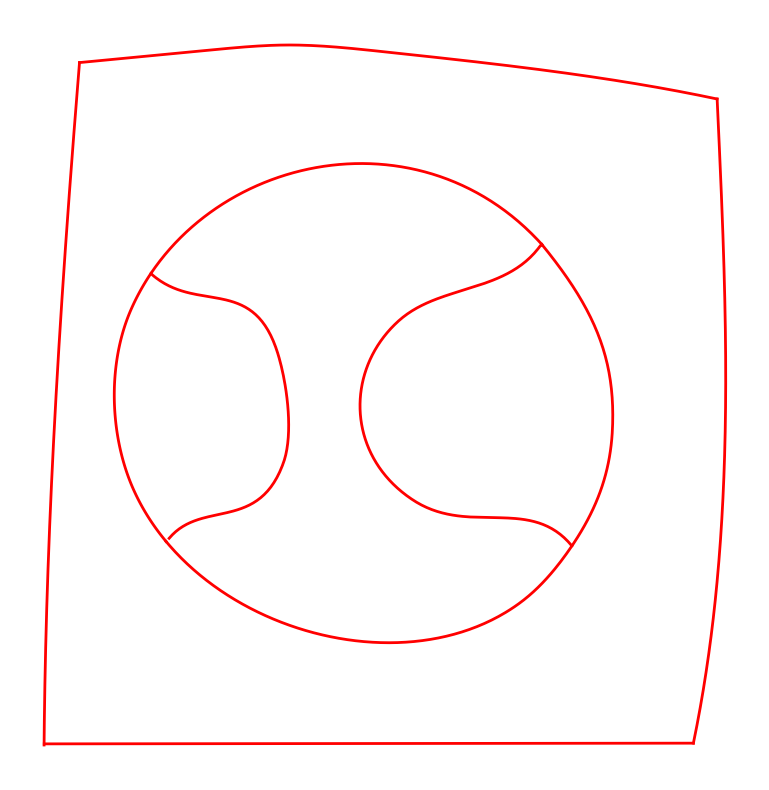

Regualrised Image
--------------


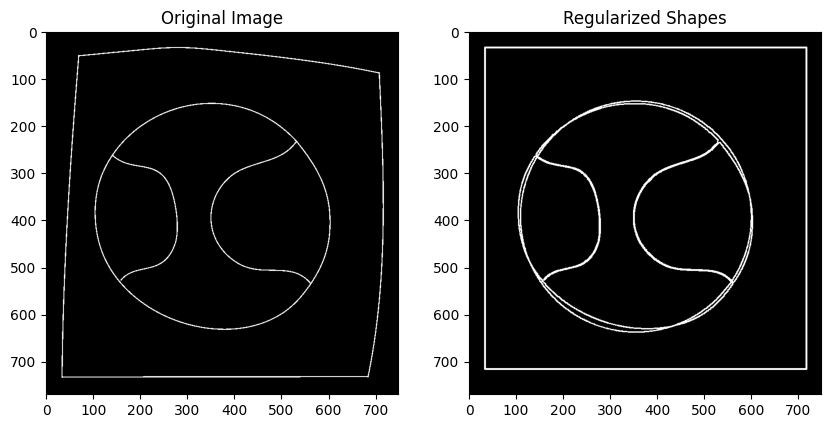

Symmetry Image
--------------


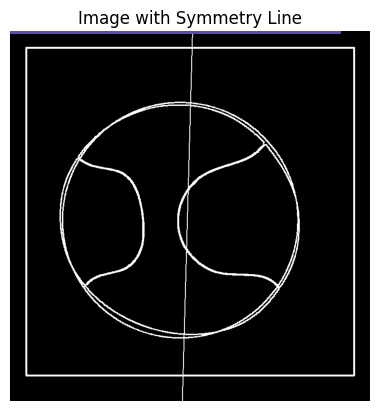

Detected Symmetry Type: Vertical Symmetry


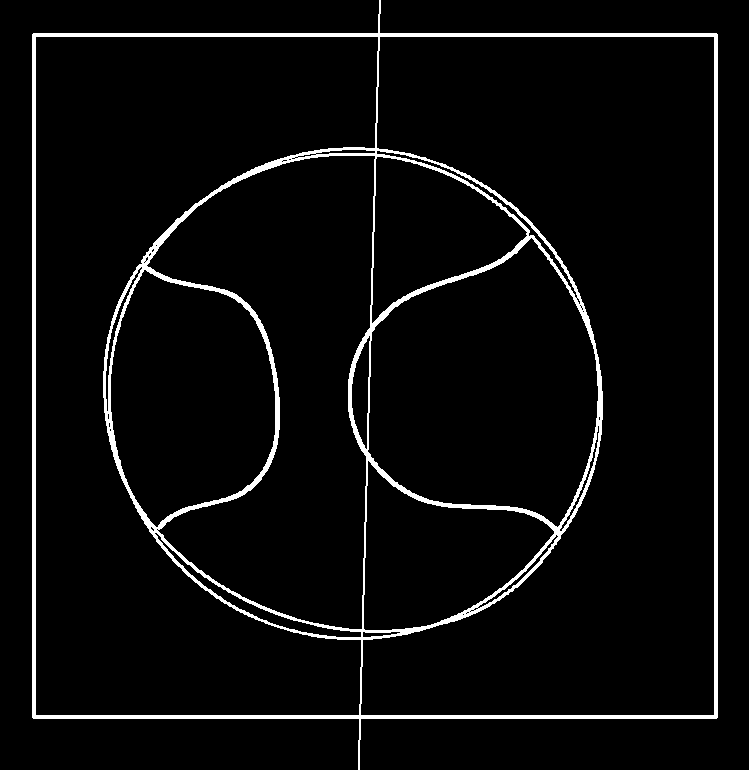

In [ ]:
csv_path = '/content/problems/problems/frag1.csv'
print("Original Image")
print("--------------")
plot_png(read_csv(csv_path), 'r', save_path='output_plot1.png')


pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
print("Regualrised Image")
print("--------------")
pipeline.regularize(f'/content/output_plot1.png', '/content/output_regularised1.png')


print("Symmetry Image")
print("--------------")
result_image = symmetry_detect('output_regularised1.png')
cv2_imshow(result_image)

Original Image
--------------


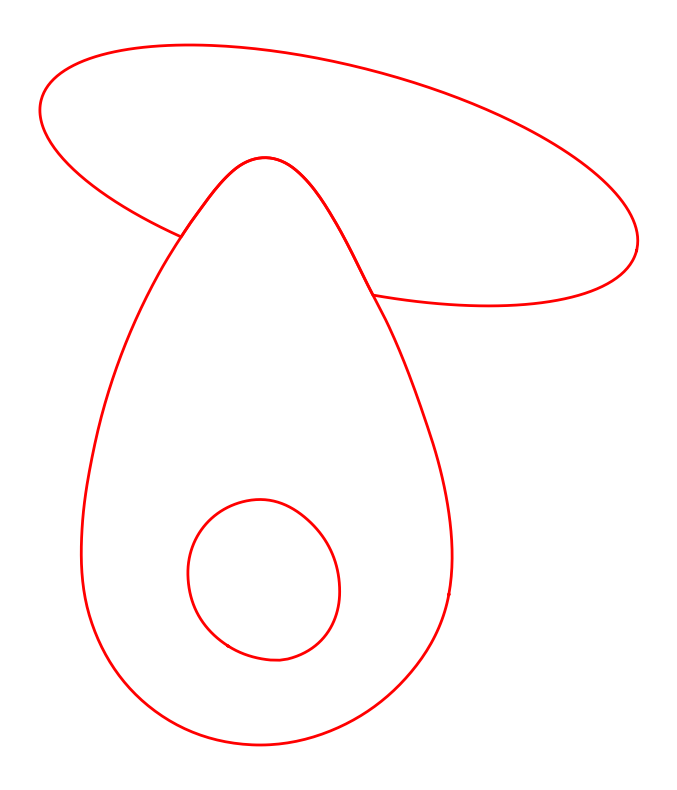

Regualrised Image
--------------


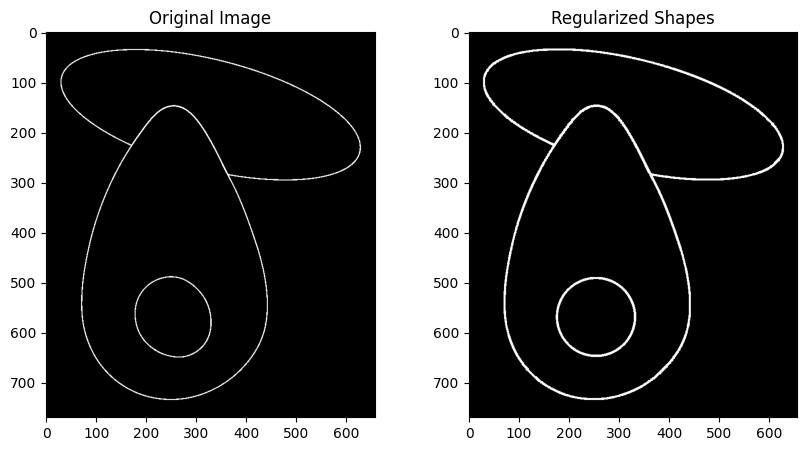

Symmetry Image
--------------


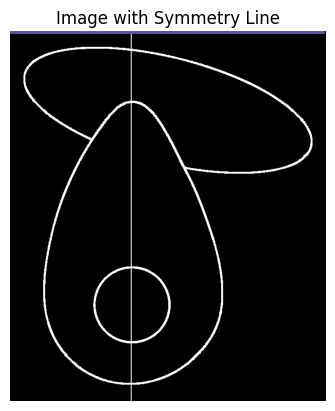

Detected Symmetry Type: Vertical Symmetry


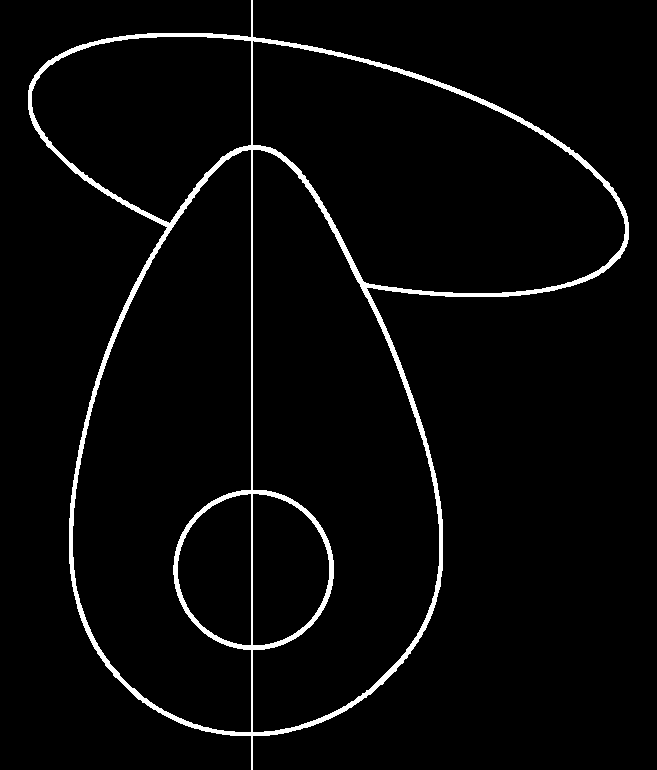

In [ ]:
print("Original Image")
print("--------------")
csv_path = '/content/problems/problems/occlusion1.csv'
plot_png(read_csv(csv_path), 'r', save_path='output_plot2.png')


print("Regualrised Image")
print("--------------")
pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
pipeline.regularize(f'/content/output_plot2.png', '/content/output_regularised2.png')


print("Symmetry Image")
print("--------------")
result_image = symmetry_detect('output_regularised2.png')
cv2_imshow(result_image)

Original Image
--------------


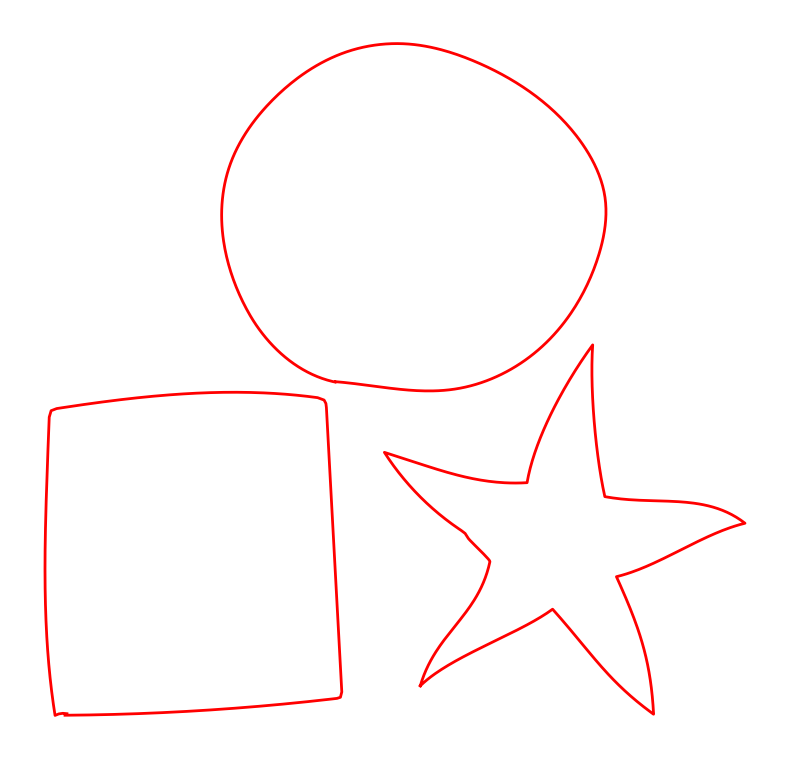

Regualrised Image
--------------


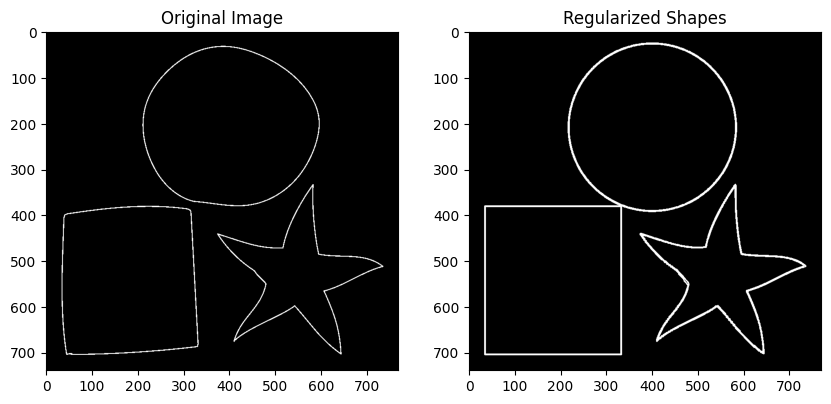

In [ ]:
print("Original Image")
print("--------------")
csv_path = '/content/problems/problems/isolated.csv'
plot_png(read_csv(csv_path), 'r', save_path='output_plot3.png')


pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
print("Regualrised Image")
print("--------------")
pipeline.regularize(f'/content/output_plot3.png', '/content/output_regularised3.png')

As, the star is not regularised here, we are using a seperate algo, which detects and regularises the star

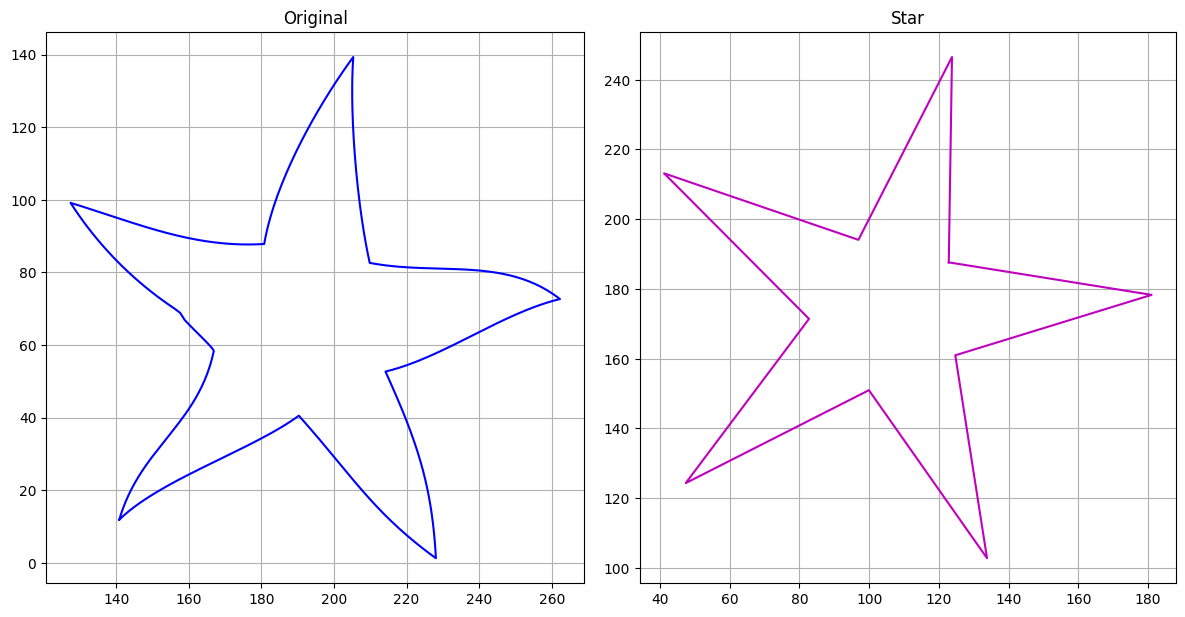

In [ ]:
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull


def regularize_shape(points, shape='star', num_points=100):
    if shape != 'star':
        raise ValueError("Invalid shape. Only 'star' is supported.")

    x, y = points[:, 0], points[:, 1]

    x_center, y_center = np.mean(x), np.mean(y)
    max_radius = np.max(np.sqrt((x - x_center)**2 + (y - y_center)**2))

    t_star = np.linspace(0, 2 * np.pi, 11)
    r_star = np.array([max_radius * (0.3 if i % 2 == 0 else 1) for i in range(11)])
    x_reg = r_star * np.cos(t_star) + x_center
    y_reg = r_star * np.sin(t_star) + y_center

    theta = np.radians(40)
    x_rot = x_reg * np.cos(theta) - y_reg * np.sin(theta)
    y_rot = x_reg * np.sin(theta) + y_reg * np.cos(theta)

    return np.column_stack((x_rot, y_rot))


def plot_shapes(original, star):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(original[:, 0], original[:, 1], 'b-')
    axs[0].set_title('Original')

    axs[1].plot(star[:, 0], star[:, 1], 'm-')
    axs[1].set_title('Star')

    for ax in axs.flat:
        ax.set_aspect('equal')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

csv_path = '/content/problems/problems/isolated.csv'
path_XYs = read_csv(csv_path)

num_val = 1
for XYs in path_XYs:
    for points in XYs:
      if num_val == 2:
        star_reg = regularize_shape(points, 'star')
        plot_shapes(points, star_reg)
      else:
        pass
      num_val+=1


Regualrised Image
--------------


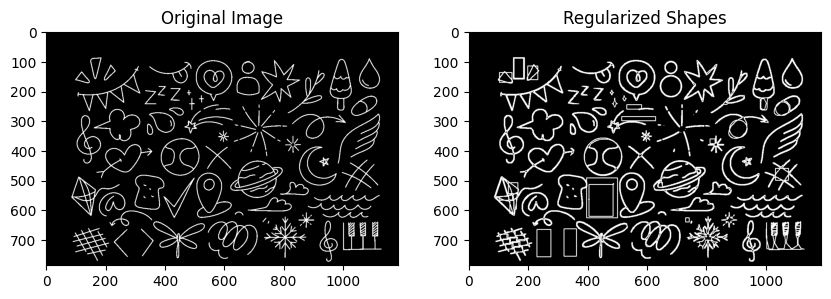

In [ ]:
# Here, doodle is the image on the second page of the problem statement pdf

pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
print("Regualrised Image")
print("--------------")
pipeline.regularize(f'/content/doodle.png', '/content/output_regularised4.png')

Original Image
--------------


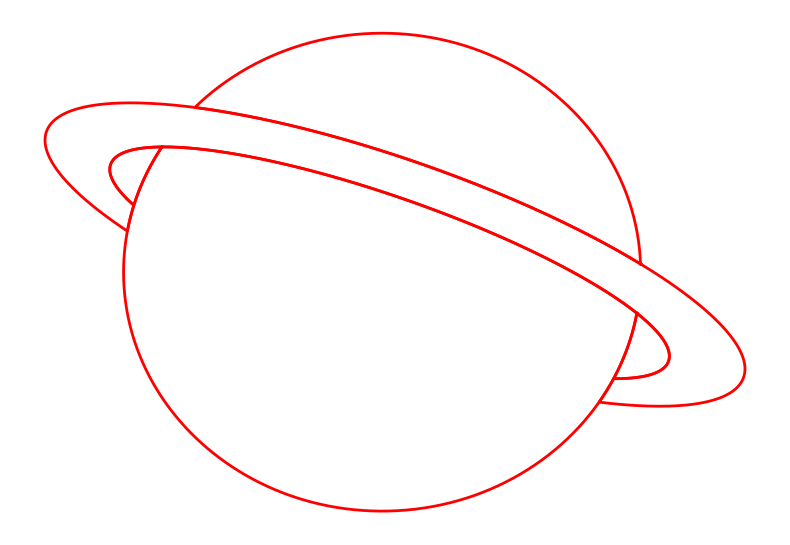

Regualrised Image
--------------


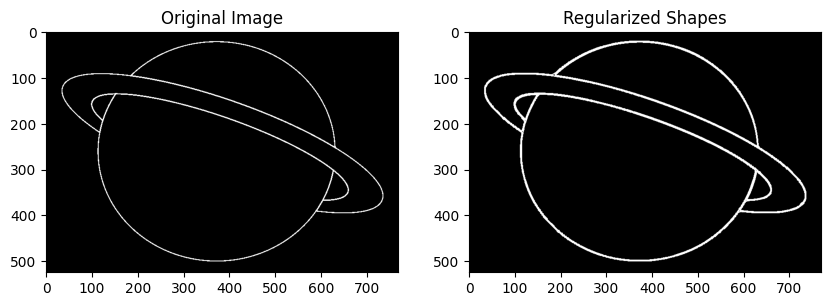

Symmetry Image
--------------


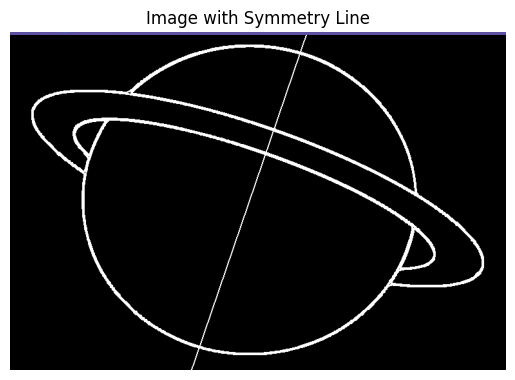

Detected Symmetry Type: Diagonal Symmetry


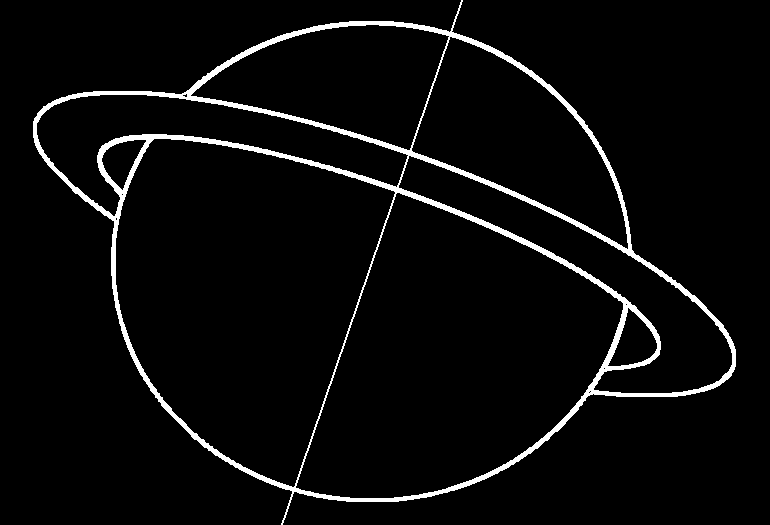

In [ ]:
print("Original Image")
print("--------------")
csv_path = '/content/problems/problems/occlusion2.csv'
plot_png(read_csv(csv_path), 'r', save_path='output_plot5.png')


print("Regualrised Image")
print("--------------")
pipeline = ShapeRegularizationPipeline(num_points=1000, alpha=0.9)
pipeline.regularize(f'/content/output_plot5.png', '/content/output_regularised5.png')


print("Symmetry Image")
print("--------------")
result_image = symmetry_detect('output_regularised5.png')
cv2_imshow(result_image)

Our base model is not able to detect and solve for straight lines, so we are using a seperate model for line regularisation

**Note**: This strictly works only for straight line diagram plots

As our model was not able to detect between straight lines and square so we have to use another set of algorithm for line regularisation.

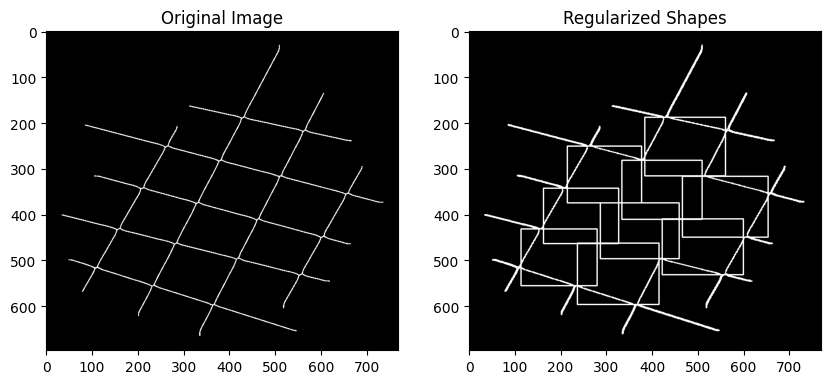

In [ ]:
from skimage.measure import LineModelND, ransac
from sklearn.utils import shuffle
from scipy.optimize import curve_fit
from shapely.geometry import LineString
from shapely.affinity import affine_transform

import numpy as np

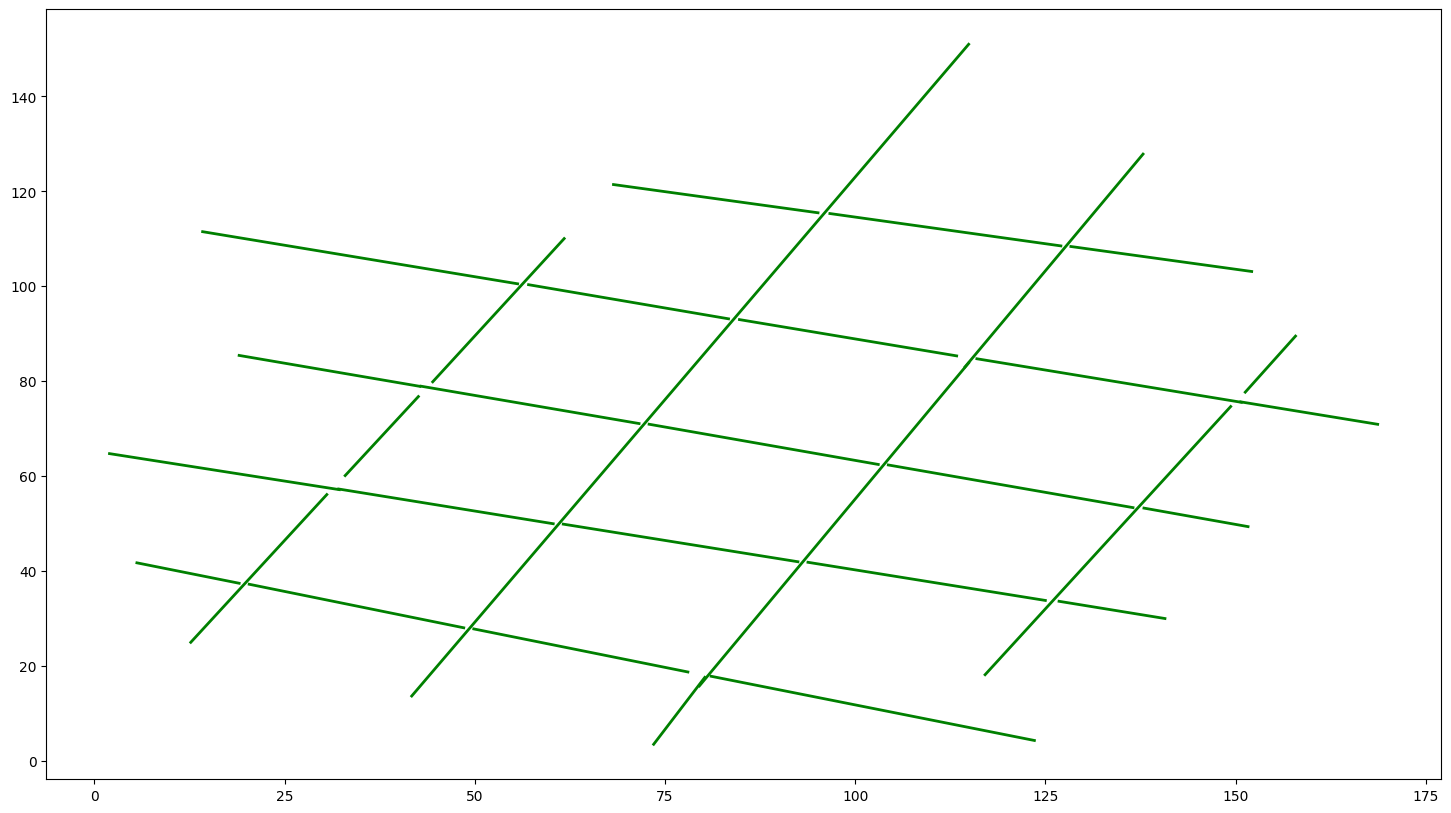

In [ ]:
def regularize_lines(points, threshold=1):
    points = np.array(points)
    all_lines = []

    while len(points) >= 2:
        model_robust, inliers = ransac(points, LineModelND, min_samples=2, residual_threshold=threshold, max_trials=500)
        inlier_points = points[inliers]

        if len(inlier_points) < 2:
            break

        line_x = np.array([inlier_points[:, 0].min(), inlier_points[:, 0].max()])
        line_y = model_robust.predict_y(line_x)

        all_lines.append((line_x, line_y))

        points = np.delete(points, inliers, axis=0)

    return all_lines

def plot_regularized_shapes(frag):
    plt.figure(figsize=(18,10))
    for shape in frag:
        lines = regularize_lines(shape[0])
        for line_x, line_y in lines:
            plt.plot(line_x, line_y, color='green', linewidth=2)
    plt.show()

lines_read = read_csv('/content/problems/problems/frag2.csv')
plot_regularized_shapes(lines_read)


### Detection

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from shapely.geometry.polygon import orient
from math import sqrt, pi

In [ ]:
def detect_shapes(input_path):
    def classify_shape(contour):
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        num_vertices = len(approx)

        if num_vertices < 3:
            return 'unknown'

        if num_vertices >= 3:
            points = [tuple(pt[0]) for pt in approx]
            if len(points) < 3:
                return 'unknown'
            try:
                poly = Polygon(points)
                area = poly.area
                perimeter = poly.length

                if num_vertices > 5:
                    circularity = (4 * np.pi * area) / (perimeter ** 2)
                    if circularity > 0.8:
                        return 'circle'
                    else:
                        return 'ellipse'

                if num_vertices == 4:
                    (x, y, w, h) = cv2.boundingRect(contour)
                    aspect_ratio = w / float(h)
                    if 0.9 <= aspect_ratio <= 1.1:
                        return 'square'
                    else:
                        return 'rectangle'

                if num_vertices >= 5:
                    angles = []
                    for i in range(num_vertices):
                        p1 = np.array(approx[i][0])
                        p2 = np.array(approx[(i + 1) % num_vertices][0])
                        p3 = np.array(approx[(i + 2) % num_vertices][0])
                        angle = np.arccos(np.clip(np.dot(p2 - p1, p3 - p2) / (np.linalg.norm(p2 - p1) * np.linalg.norm(p3 - p2)), -1.0, 1.0))
                        angles.append(np.degrees(angle))
                    angles = np.array(angles)
                    if np.all(np.abs(angles - angles[0]) < 10):
                        return 'regularPolygon'

                if num_vertices == 4:
                    contours_approx = [cv2.approxPolyDP(contour, epsilon, True) for contour in contours]
                    for approx in contours_approx:
                        rect = cv2.boundingRect(approx)
                        x, y, w, h = rect
                        if cv2.contourArea(approx) > 0.8 * (w * h):
                            return 'roundedRectangle'

                if num_vertices >= 5:
                    distances = [np.linalg.norm(np.array(approx[i][0]) - np.array(approx[(i + 1) % num_vertices][0])) for i in range(num_vertices)]
                    if np.all(np.abs(np.diff(distances)) < 10):
                        return 'star'

                if num_vertices == 2:
                    return 'straightLine'

            except ValueError:
                return 'unknown'

        return 'unknown'

    def draw_and_count_shapes(image, contours):
        shape_counts = {name: 0 for name in class_names}

        for contour in contours:
            shape = classify_shape(contour)
            if shape in shape_counts:
                shape_counts[shape] += 1
            else:
                shape_counts['unknown'] += 1

            (x, y, w, h) = cv2.boundingRect(contour)
            color = (0, 255, 0)
            cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)

        return shape_counts

    class_names = ['circle', 'ellipse', 'rectangle', 'regularPolygon', 'roundedRectangle', 'star', 'straightLine', 'unknown']

    image = cv2.imread(input_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shape_counts = draw_and_count_shapes(image, contours)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    print("Detected shapes and their counts:")
    for shape, count in shape_counts.items():
        print(f"{shape}({count})")

    return shape_counts

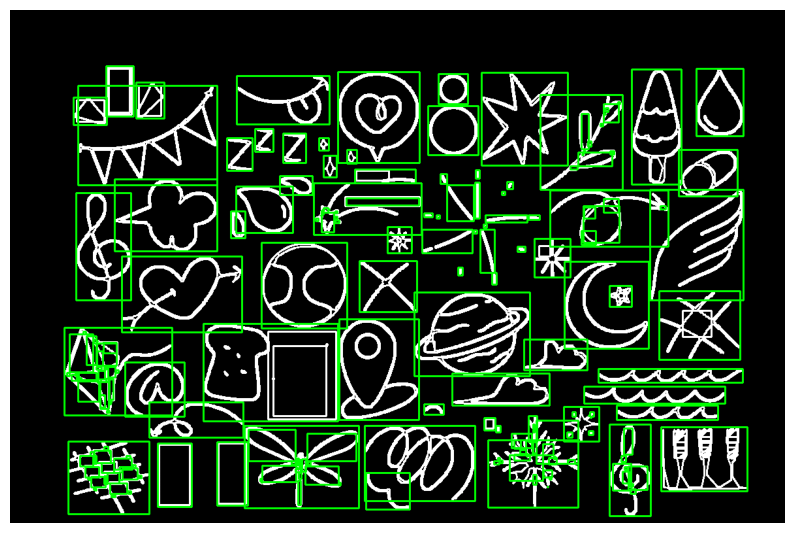

Detected shapes and their counts:
circle(13)
ellipse(145)
rectangle(15)
regularPolygon(0)
roundedRectangle(0)
star(7)
straightLine(0)
unknown(35)


In [ ]:
shape_counts = detect_shapes('output_regularised4.png')

In [ ]:
def detect_shape(XYs):
    def is_circle(points):
        if len(points) < 5:
            return False
        center = np.mean(points, axis=0)
        distances = np.linalg.norm(points - center, axis=1)
        mean_distance = np.mean(distances)
        return np.std(distances) < 0.1 * mean_distance

    def is_polygon(points):
        return len(points) >= 3

    def is_line(points):
        if len(points) != 2:
            return False
        dist = np.linalg.norm(points[1] - points[0])
        return dist > 0.1

    def is_rectangle(points):
        if len(points) != 4:
            return False
        dists = [np.linalg.norm(points[i] - points[j]) for i in range(4) for j in range(i + 1, 4)]
        dists.sort()
        return (np.isclose(dists[0], dists[1]) and
                np.isclose(dists[2], dists[3]) and
                np.isclose(dists[4], dists[5]) and
                np.isclose(dists[0], dists[2]) and
                np.isclose(dists[1], dists[3]) and
                np.isclose(dists[4], dists[5]))

    def is_square(points):
        if len(points) != 4:
            return False
        dists = [np.linalg.norm(points[i] - points[j]) for i in range(4) for j in range(i + 1, 4)]
        dists.sort()
        return (np.isclose(dists[0], dists[1]) and
                np.isclose(dists[2], dists[3]) and
                np.isclose(dists[4], dists[5]) and
                np.isclose(dists[0], dists[2]) and
                np.isclose(dists[1], dists[3]) and
                np.isclose(dists[4], dists[5]) and
                np.isclose(dists[0], dists[1]))

    def is_star(points):
        return len(points) >= 5

    def is_valid_shape(points):
        return len(points) > 0 and len(points[0]) == 2

    if not is_valid_shape(XYs):
        return "Unknown"

    if is_circle(XYs):
        return "Circle"
    elif is_square(XYs):
        return "Square"
    elif is_rectangle(XYs):
        return "Rectangle"
    elif is_polygon(XYs):
        return "Polygon"
    elif is_line(XYs):
        return "Line"
    elif is_star(XYs):
        return "Star"
    else:
        return "Unknown"

def detect_shapes_from_csv(csv_path):
    path_XYs = read_csv(csv_path)
    shapes = []
    for shape_list in path_XYs:
        for shape in shape_list:
            if isinstance(shape, np.ndarray):
                shape_type = detect_shape(shape)
                shapes.append(shape_type)
            else:
                shapes.append("Invalid shape data")
    return shapes

csv_path = '/content/problems/problems/isolated.csv'
shapes = detect_shapes_from_csv(csv_path)
print(shapes)

['Circle', 'Polygon', 'Polygon']


### Triangulation

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    return val

def convexHull(points):
    n = len(points)
    if n < 3:
        return []

    l = 0
    for i in range(1, len(points)):
        if points[i][0] < points[l][0]:
            l = i
        elif points[i][0] == points[l][0]:
            if points[i][1] > points[l][1]:
                l = i

    hull = []
    p = l
    while True:
        hull.append(points[p])
        q = (p + 1) % n
        for i in range(n):
            if orientation(points[p], points[i], points[q]) < 0:
                q = i
        p = q
        if p == l:
            break

    return hull

def dist(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def cost(p1, p2, p3):
    return dist(p1, p2) + dist(p2, p3) + dist(p3, p1)

def triangulation(points):
    n = len(points)
    if n < 3:
        return []

    table = [[(float('inf'), -1)] * n for _ in range(n)]
    for gap in range(n):
        for j in range(gap, n):
            i = j - gap
            if j < i + 2:
                table[i][j] = (0.0, -1)
            else:
                for k in range(i + 1, j):
                    val = table[i][k][0] + table[k][j][0] + cost(points[i], points[j], points[k])
                    if table[i][j][0] > val:
                        table[i][j] = (val, k)

    queue = [[0, n - 1]]
    triangles = []
    while queue:
        x = queue.pop(0)
        k = table[x[0]][x[1]][1]
        if k - x[0] > 2:
            queue.append([x[0], k])
        if x[1] - k > 2:
            queue.append([k, x[1]])
        triangles.append([points[x[0]], points[k], points[x[1]]])

    return triangles

def detect_shapes(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for cnt in contours:
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        if len(approx) >= 3:
            if len(approx) == 3:
                shape = 'Triangle'
            elif len(approx) == 4:
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = float(w) / h
                shape = 'Rectangle' if 0.9 <= aspect_ratio <= 1.1 else 'Quadrilateral'
            else:
                area = cv2.contourArea(approx)
                hull = cv2.convexHull(approx, returnPoints=True)
                hull_area = cv2.contourArea(hull)
                shape = 'Circle' if abs(1 - (area / hull_area)) <= 0.2 else 'Polygon'
            shapes.append((shape, approx))

    return shapes

def plot_shapes_and_triangles(image_path):
    shapes = detect_shapes(image_path)

    image = plt.imread(image_path)
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)

    for shape, contour in shapes:
        polygon = [(point[0][0], point[0][1]) for point in contour]
        convex_polygon = convexHull(polygon)
        polygon_patch = patches.Polygon(convex_polygon, closed=True, edgecolor='white', facecolor='none', linewidth=2)
        ax.add_patch(polygon_patch)

        color = {'Triangle': 'blue', 'Rectangle': 'green', 'Circle': 'orange', 'Polygon': 'purple'}
        ax.text(np.mean([p[0] for p in polygon]), np.mean([p[1] for p in polygon]),
                shape, color=color.get(shape, 'black'), fontsize=12, weight='bold')

        triangles = triangulation(convex_polygon)
        for triangle in triangles:
            triangle_patch = patches.Polygon(triangle, closed=True, edgecolor='red', facecolor='none', linestyle='--')
            ax.add_patch(triangle_patch)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

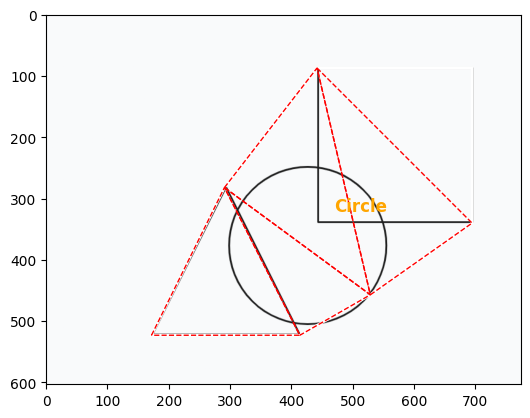

In [ ]:
image_path = 'a6.png'
plot_shapes_and_triangles(image_path)

### Shape Completion

In [ ]:
import gdown
!gdown 1TUVYrFghJfXaLElIZLKLYO3FSpPStDPM

Downloading...
From: https://drive.google.com/uc?id=1TUVYrFghJfXaLElIZLKLYO3FSpPStDPM
To: /content/shape_completion.zip
100% 10.3M/10.3M [00:00<00:00, 41.9MB/s]


In [ ]:
!pip install --upgrade scipy==1.13

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.spatial import ConvexHull, Delaunay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def bezier_curve(points, n=3, num_points=1000):
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))
    for i in range(n + 1):
        bernstein = comb(n, i) * (t ** i) * ((1 - t) ** (n - i))
        curve += np.outer(bernstein, points[i])
    return curve

def fit_bezier(XYs, n=3):
    bezier_curves = []
    for XY in XYs:
        if len(XY) > n:
            X = np.linspace(0, 1, len(XY)).reshape(-1, 1)
            poly = PolynomialFeatures(degree=n).fit_transform(X)
            model = LinearRegression().fit(poly, XY)
            t = np.linspace(0, 1, 100).reshape(-1, 1)
            poly_t = PolynomialFeatures(degree=n).fit_transform(t)
            bezier_points = model.predict(poly_t)
            bezier_curves.append(bezier_points)
    return bezier_curves

def complete_shapes(XYs):
    completed_shapes = []
    for XY in XYs:
        if len(XY) > 5:
            try:
                hull = ConvexHull(XY)
                completed_shapes.append(XY[hull.vertices])
            except:
                if len(XY) > 3:
                    delaunay = Delaunay(XY)
                    for simplex in delaunay.simplices:
                        completed_shapes.append(XY[simplex])
    return completed_shapes

def plot(path_XYs, bezier_curves, completed_shapes, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(12, 8))

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, markersize=5)

    for i, bezier in enumerate(bezier_curves):
        c = colours[i % len(colours)]
        if bezier.size > 0:
            ax.plot(bezier[:, 0], bezier[:, 1], c=c, linewidth=2)

    for i, shape in enumerate(completed_shapes):
        c = colours[i % len(colours)]
        ax.plot(shape[:, 0], shape[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    ax.set_title('Bézier Curves and Completed Shapes')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.grid(True)
    plt.show()

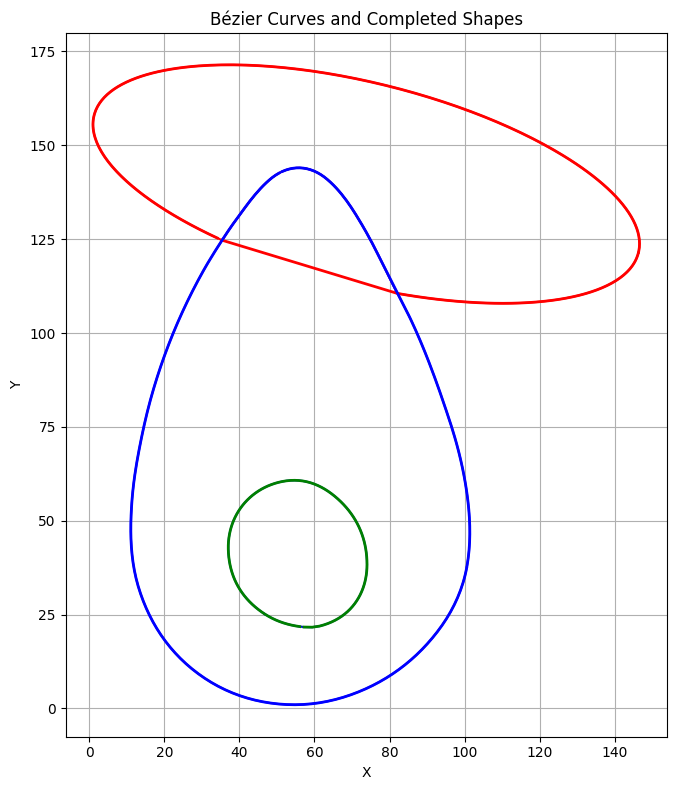

In [ ]:
csv_path = '/content/problems/problems/occlusion1.csv'

path_XYs = read_csv(csv_path)
bezier_curves = fit_bezier(path_XYs, n=3)
completed_shapes = complete_shapes([XY for XYs in path_XYs for XY in XYs])
plot(path_XYs, bezier_curves, completed_shapes, colours=['r', 'b', 'g', 'y'])

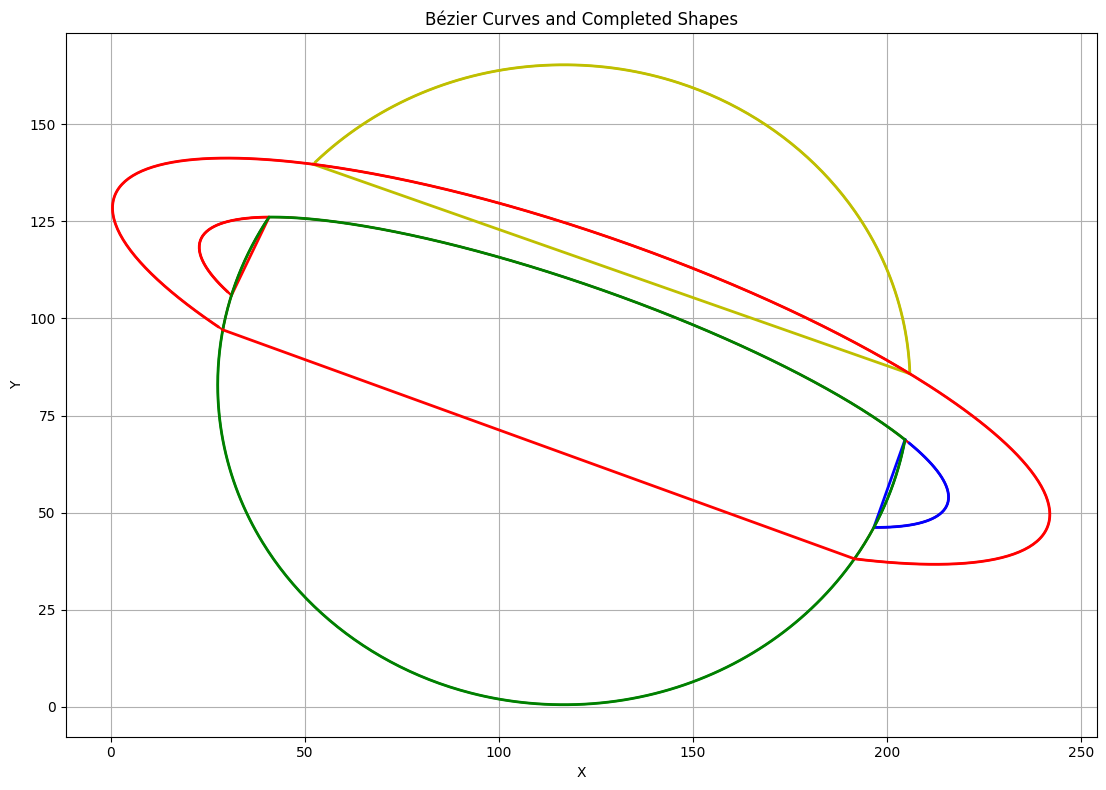

In [ ]:
csv_path = '/content/problems/problems/occlusion2.csv'

path_XYs = read_csv(csv_path)
bezier_curves = fit_bezier(path_XYs, n=3)
completed_shapes = complete_shapes([XY for XYs in path_XYs for XY in XYs])
plot(path_XYs, bezier_curves, completed_shapes, colours=['r', 'b', 'g', 'y'])